<h1><center>Sample design - Stress/Strain anisotropy tester</center></h1>

### Parameters for file to test

This is the **only section** you must edit !

For the constitutive model, you may choose between :
- '1-tanhplastic'
- '2-perfectplasticity'


In [1]:
# list available samples
from os import listdir
meshpath = './resultstester_GAP/'
mesh_list = [x for x in listdir(meshpath) if x.endswith('.xdmf')]
mesh_list

['2hole.xdmf',
 '2notch.xdmf',
 'test_array_ellipse.xdmf',
 'test_clover.xdmf',
 'test_clover_rand.xdmf',
 'test_loop_array_2fold.xdmf',
 'test_loop_array_3fold.xdmf',
 'test_NPR.xdmf',
 'test_NPR_rounded.xdmf',
 'test_NPR_rounded_45.xdmf',
 'test_NPR_rounded_90.xdmf',
 'test_NPR_rounded_rand.xdmf',
 'test_NPR_rounded_swivel.xdmf',
 'test_simplehole_discA1.xdmf',
 'test_simplehole_ellipseA12.xdmf',
 'test_simplehole_rectangleA12.xdmf',
 'test_simplehole_squareA1.xdmf',
 'test_simplehole_squareB1.xdmf',
 'test_withouthole.xdmf']

In [2]:
meshfile = "test_clover.xdmf"                    # with .xdmf
meshpath = './output_files/'
constitutive_model = '1-tanhplastic'

sample_height=1     #IMPORTANT TO CHECK       #height of the sample in the mesh file (m)

In [3]:
#Test loading profile
T_max = 40                                    #loading time length (s)
e_max = 0.005                                   #max upper boundary strain (no unit)
nb_steps = 15                                 #number of time steps during loading (default is 10)

In [4]:
# Mechanical Properties for sample design evaluation
# (default is given for steel https://www.matweb.com/search/datasheet.aspx?bassnum=MS0001&ckck=1 )

E_float = 200*1e9                                     #Young modulus (Pa)        default 200*1e9
nu_float = 0.25                                       #Poisson ratio (no unit)   default 0.25
sigma_y0_float = 350*1e6                              #Yield stress (Pa)         default 350*1e6

#MODEL PARAMETERS :
    #1-tanhplastic
sp=10
amp=0.1
    #2-perfectplasticity
#no parameters to define
    #3-

In [5]:
# To change the number of discrete segments to calculate anisotropy score :
# (default is 200)
n_seg=200
rel_thresh=1/3

In [6]:
from fenics import *
from dolfin_adjoint import *
# import pygmsh_mesh_functions
# from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For quality evaluation
from anisotropyv3 import *
from anisotropy_density import *

## Evaluate strain diversity

### load data

In [7]:
from scipy.io import loadmat
filename = './resultstester_GAP/'+meshfile+'/'+'data.mat'
epsilon = loadmat(filename)['epsilon']
n_element = epsilon.shape[0]

### Calculate anisotropic score

In [8]:
n_frame = epsilon.shape[3]
strain = np.arange(n_frame)/(n_frame-1)*e_max

i_frame = round(0.001/e_max*(nb_steps-1))

epsilon_normal = np.zeros((n_element,n_frame))
epsilon_shear = np.zeros((n_element,n_frame))

In [9]:
for it in tqdm(range(n_frame)):
    epsilon_t = epsilon[:,:,:,it].reshape(n_element,4)
    
    epsilon_normal[:,it] = (epsilon_t[:,0] - epsilon_t[:,3])/2
    epsilon_shear[:,it] = epsilon_t[:,2]

epsilon_radius2 = (epsilon_normal**2 + epsilon_shear**2).reshape(n_frame*n_element).tolist()
epsilon_all = np.vstack((epsilon_normal.reshape(n_frame*n_element),epsilon_shear.reshape(n_frame*n_element))).T.tolist()
epsilon_i = np.vstack((epsilon_normal[:,i_frame],epsilon_shear[:,i_frame])).T.tolist()

Score_strain_density = anisotropy_score_density(epsilon_all,n_segments=60)
Score_strain_radius = anisotropy_score_radius(epsilon_all,n_segments=60)
Score_strain_harmonics = anisotropy_score_harmonics(epsilon_all,n_segments=60)
Score_strain_gap = [GapScore(epsilon_i,threshold=0.75),
                    GapScore(epsilon_i,threshold=0.50),
                    GapScore(epsilon_i,threshold=0.25),
                    GapScore(epsilon_i,threshold=0.00)]
print('Score_strain_density = {}'.format(Score_strain_density))
print('Score_strain_radius = {}'.format(Score_strain_radius))
print('Score_strain_harmonics = {}'.format(Score_strain_harmonics))
print('Score_strain_gap = {}'.format(Score_strain_gap))

100%|██████████| 16/16 [00:00<00:00, 5025.38it/s]


Score_strain_density = 0.08856712299926117
Score_strain_radius = 1.274286262103572
Score_strain_harmonics = 0.11604961421121232
Score_strain_gap = [0.6476513482198025, 0.21576381428210015, 0.059688655456738515, 0.020347598894969936]


### Plot the result

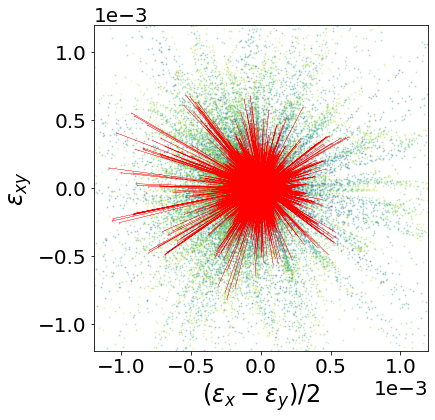

In [10]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = cm.viridis(np.linspace(0, 1, n_frame))

for it in range(n_frame):
    ax.plot(epsilon_normal[:,it],epsilon_shear[:,it],'.',color=colors[it],alpha=0.25,markersize=2)

epsilon_lines = np.vstack((
                    np.vstack((epsilon_normal[:,i_frame],
                           np.zeros_like(epsilon_normal[:,i_frame]))).T.reshape(2*n_element),
                    np.vstack((epsilon_shear[:,i_frame],
                           np.zeros_like(epsilon_shear[:,i_frame]))).T.reshape(2*n_element)
                    ))
    
ax.plot(epsilon_lines[0],epsilon_lines[1],'-',color='r',lw=0.25)

# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-.0012, .0012)
ax.set_ylim(-.0012, .0012)
ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1])/1000)
ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1])/1000)
ax.set_xlabel('$(\epsilon_x - \epsilon_y)/2$',fontsize=24)
ax.set_ylabel('$\epsilon_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

## Evaluate stress diversity

### load data

In [11]:
from scipy.io import loadmat
filename = './resultstester_Gap/'+meshfile+'/'+'data.mat'
sigma = loadmat(filename)['sigma']
n_element = sigma.shape[0]

### Calculate anisotropic score

In [12]:
n_frame = sigma.shape[3]
strain = np.arange(n_frame)/(n_frame-1)*e_max

sigma_normal = np.zeros((n_element,n_frame))
sigma_shear = np.zeros((n_element,n_frame))

In [13]:
for it in tqdm(range(n_frame)):
    sigma_t = sigma[:,:,:,it].reshape(n_element,4)
    
    sigma_normal[:,it] = (sigma_t[:,0] - sigma_t[:,3])/2
    sigma_shear[:,it] = sigma_t[:,2]

sigma_radius2 = (sigma_normal**2 + sigma_shear**2).reshape(n_frame*n_element).tolist()
sigma_all = np.vstack((sigma_normal.reshape(n_frame*n_element),sigma_shear.reshape(n_frame*n_element))).T.tolist()
# sigma_annular = [x for x in sigma_all if x[0]**2+x[1]**2>threshold]
sigma_i = np.vstack((sigma_normal[:,i_frame],sigma_shear[:,i_frame])).T.tolist()

Score_stress_density = anisotropy_score_density(epsilon_all,n_segments=60)
Score_stress_radius = anisotropy_score_radius(epsilon_all,n_segments=60)
Score_stress_harmonics = anisotropy_score_harmonics(epsilon_all,n_segments=60)
Score_stress_gap = [GapScore(epsilon_i,threshold=0.75),
                    GapScore(epsilon_i,threshold=0.50),
                    GapScore(epsilon_i,threshold=0.25),
                    GapScore(epsilon_i,threshold=0.00)]
print('Score_stress_density = {}'.format(Score_stress_density))
print('Score_stress_radius = {}'.format(Score_stress_radius))
print('Score_stress_harmonics = {}'.format(Score_stress_harmonics))
print('Score_stress_gap = {}'.format(Score_stress_gap))

100%|██████████| 16/16 [00:00<00:00, 4070.16it/s]


Score_stress_density = 0.08856712299926117
Score_stress_radius = 1.274286262103572
Score_stress_harmonics = 0.11604961421121232
Score_stress_gap = [0.6476513482198025, 0.21576381428210015, 0.059688655456738515, 0.020347598894969936]


### Plot the result

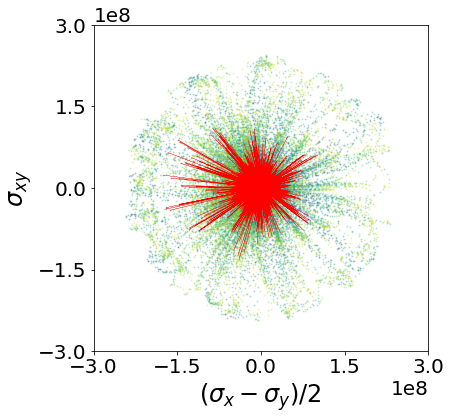

In [14]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = cm.viridis(np.linspace(0, 1, n_frame))

for it in range(n_frame):
    ax.plot(sigma_normal[:,it],sigma_shear[:,it],'.',color=colors[it],alpha=0.25,markersize=2)

sigma_lines = np.vstack((
                    np.vstack((sigma_normal[:,i_frame],
                           np.zeros_like(sigma_normal[:,i_frame]))).T.reshape(2*n_element),
                    np.vstack((sigma_shear[:,i_frame],
                           np.zeros_like(sigma_shear[:,i_frame]))).T.reshape(2*n_element)
                    ))
    
ax.plot(sigma_lines[0],sigma_lines[1],'-',color='r',lw=0.25)

# print('rho = {:0.4f}'.format(corr[0,1]))
    
# ax.set_xlim(-.0012, .0012)
# ax.set_ylim(-.0012, .0012)
ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1])*3e8)
ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1])*3e8)
ax.set_xlabel('$(\sigma_x - \sigma_y)/2$',fontsize=24)
ax.set_ylabel('$\sigma_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

In [15]:
Score_density = np.array([Score_strain_density,Score_stress_density])
Score_radius = np.array([Score_strain_radius,Score_stress_radius])
Score_h = np.array([Score_strain_harmonics,Score_stress_harmonics])
Score_gap = np.array([Score_strain_gap,Score_stress_gap])

from scipy.io import savemat
mdic = {'Score_density':Score_density,'Score_radius':Score_radius,'Score_h':Score_h, 'Score_gap':Score_gap}
# savemat('./resultstester_GAP/'+meshfile+'/'+'score.mat', mdic)

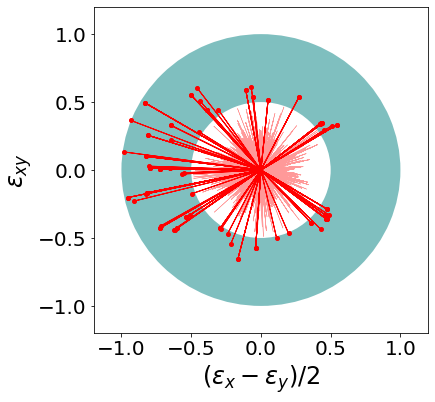

In [16]:
## Plot Demo
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

percentage = 50/100

from matplotlib.patches import Circle, Wedge, Polygon
circle_rmax = Wedge((0,0),1,0,360,width=percentage,fc='teal',alpha=0.5)

ax.add_patch(circle_rmax)

np.random.seed(seed=2)
n_rays = n_element
i_rays = np.random.choice(n_element,n_rays)
# colors = cm.viridis(np.linspace(0, 1, n_frame))

# for it in range(n_frame):
#     ax.plot(epsilon_normal[:,it],epsilon_shear[:,it],'.',color=colors[it],alpha=0.25,markersize=2)
r = np.sqrt(epsilon_normal[i_rays,i_frame]**2+epsilon_shear[i_rays,i_frame]**2)
max_r = np.max(r)
epsilon_lines = np.vstack((
                    np.vstack((epsilon_normal[i_rays,i_frame],
                           np.zeros_like(epsilon_normal[i_rays,i_frame]))).T.reshape(2*n_rays),
                    np.vstack((epsilon_shear[i_rays,i_frame],
                           np.zeros_like(epsilon_shear[i_rays,i_frame]))).T.reshape(2*n_rays)
                    ))/max_r

i_valid = i_rays[r/max_r>= 1-percentage]

epsilon_lines_valid = np.vstack((
                    np.vstack((epsilon_normal[i_valid,i_frame],
                           np.zeros_like(epsilon_normal[i_valid,i_frame]))).T.reshape(2*len(i_valid)),
                    np.vstack((epsilon_shear[i_valid,i_frame],
                           np.zeros_like(epsilon_shear[i_valid,i_frame]))).T.reshape(2*len(i_valid))
                    ))/max_r

# ax.plot(epsilon_normal[i_rays,i_frame]/max_r,epsilon_shear[i_rays,i_frame]/max_r,'o',color='k',alpha=1,markersize=4)
ax.plot(epsilon_normal[i_valid,i_frame]/max_r,epsilon_shear[i_valid,i_frame]/max_r,'o',color='r',alpha=1,markersize=4)
ax.plot(epsilon_lines[0],epsilon_lines[1],'-',color='r',lw=0.5,alpha=0.4)
ax.plot(epsilon_lines_valid[0],epsilon_lines_valid[1],'-',color='r',lw=1)

# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel('$(\epsilon_x - \epsilon_y)/2$',fontsize=24)
ax.set_ylabel('$\epsilon_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

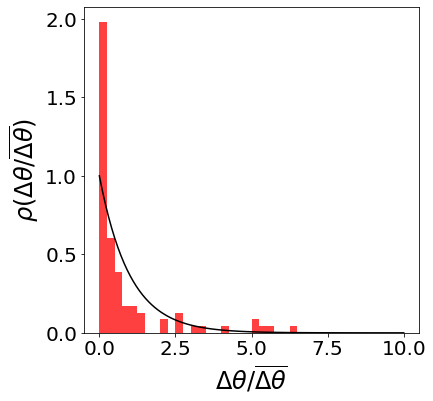

In [22]:
## Plot Histogram
from scipy.stats import expon
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

def gaps(Stress_points,threshold=5,tol=1e-14):
    A=SortCut2(Stress_points,threshold=threshold)
    THETAS=np.sort(np.arctan2(A[:,1],A[:,0]))
#     print(THETAS/np.pi)
    GAPS=(np.roll(THETAS,-1,axis=0)-THETAS)%(2*np.pi)
#     print(GAPS/np.pi)
    GAPS=GAPS[GAPS>tol]
#     print(GAPS/np.pi)
    Ngaps=len(GAPS)
    if Ngaps<=1:
        return 1
    return GAPS

gaps_list = gaps(epsilon_i,threshold=0.5,tol=1e-14)
gaps_list = gaps_list/(2*pi/len(gaps_list))
ax.hist(gaps_list,bins=40,range=[0,10],density=True, facecolor='r', alpha=0.75)

k = np.linspace(0,10,100)
exppdf = expon.pdf(k,scale=1)
ax.plot(k,exppdf,'-k')

# ax.set_xlim(-1.2, 1.2)
# ax.set_ylim(-1.2, 1.2)
# ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel(r'$\Delta\theta/\overline{\Delta\theta}$',fontsize=24)
ax.set_ylabel(r'$\rho(\Delta\theta/\overline{\Delta\theta})$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
# ax.set_xscale('log')

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

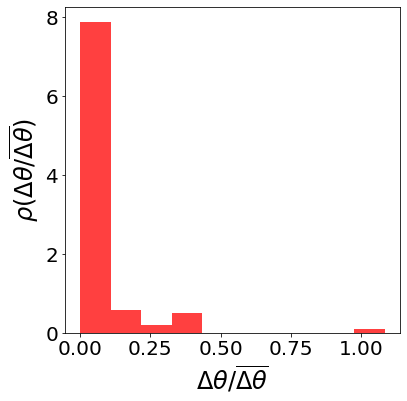

In [26]:
## Plot Histogram
from scipy.stats import expon
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

def gaps(Stress_points,threshold=5,tol=1e-14):
    A=SortCut2(Stress_points,threshold=threshold)
    THETAS=np.sort(np.arctan2(A[:,1],A[:,0]))
#     print(THETAS/np.pi)
    GAPS=(np.roll(THETAS,-1,axis=0)-THETAS)%(2*np.pi)
#     print(GAPS/np.pi)
    GAPS=GAPS[GAPS>tol]
#     print(GAPS/np.pi)
    Ngaps=len(GAPS)
    if Ngaps<=1:
        return 1
    return GAPS

gaps_list = gaps(epsilon_i,threshold=0.5,tol=1e-14)
# gaps_list = gaps_list/(2*pi/len(gaps_list))
ax.hist(gaps_list,bins=10,range=None,density=True, facecolor='r', alpha=0.75)

# k = np.linspace(0,1,100)
# exppdf = expon.pdf(k,scale=1)
# ax.plot(k,exppdf,'-k')

# ax.set_xlim(-1.2, 1.2)
# ax.set_ylim(-1.2, 1.2)
# ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel(r'$\Delta\theta/\overline{\Delta\theta}$',fontsize=24)
ax.set_ylabel(r'$\rho(\Delta\theta/\overline{\Delta\theta})$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
# ax.set_xscale('log')

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

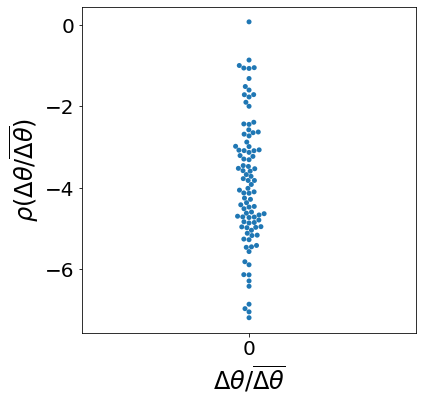

In [32]:
## Plot Histogram
from scipy.stats import expon
from matplotlib import cm
import seaborn as sns

fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)

def gaps(Stress_points,threshold=5,tol=1e-14):
    A=SortCut2(Stress_points,threshold=threshold)
    THETAS=np.sort(np.arctan2(A[:,1],A[:,0]))
#     print(THETAS/np.pi)
    GAPS=(np.roll(THETAS,-1,axis=0)-THETAS)%(2*np.pi)
#     print(GAPS/np.pi)
    GAPS=GAPS[GAPS>tol]
#     print(GAPS/np.pi)
    Ngaps=len(GAPS)
    if Ngaps<=1:
        return 1
    return GAPS

gaps_list = gaps(epsilon_i,threshold=0.5,tol=1e-14)
# gaps_list = gaps_list/(2*pi/len(gaps_list))
ax = sns.swarmplot(data=np.log(gaps_list))

# k = np.linspace(0,1,100)
# exppdf = expon.pdf(k,scale=1)
# ax.plot(k,exppdf,'-k')

# ax.set_xlim(-1.2, 1.2)
# ax.set_ylim(-1.2, 1.2)
# ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel(r'$\Delta\theta/\overline{\Delta\theta}$',fontsize=24)
ax.set_ylabel(r'$\rho(\Delta\theta/\overline{\Delta\theta})$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
# ax.set_xscale('log')

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')